# 4장 - 모델 훈련

지금까지는 머신러닝 모델과 훈련 알고리즘을 블랙박스처럼 취급했습니다. 앞 장의 연습문제를 풀어봤다면 내부가 어떻게 작동하는지 몰라도 많은 일을 처리할 수 있다는 점에 놀랐을 것입니다. 회귀 시스템을 최적화하고 숫자 이미지 분류기를 개선했으며 스팸 분류기를 처음부터 구축했지만 실제로 어떻게 작동하는지는 모릅니다. 많은 경우 구현의 상세 사항을 실제로 알아야할 필요는 없습니다.

하지만 어떻게 작동하는지 잘 이해하고 있으면 적절한 모델, 올바른 훈련 알고리즘, 작업에 맞는 좋은 하이퍼파라미터를 빠르게 찾을 수 있습니다. 작동 원리를 이해하고 있으면 디버깅이나 에러를 효율적으로 분석하는 데 도움이 됩니다. 이 장에서 언급하는 대부분의 주제는 신경망$^{neural \ network}$(2부에서 설명합니다)을 이해하고 구축하고 훈련시키는 데 필수입니다.

이 장에서는 가장 간단한 모델 중 하나인 선형 회귀부터 시작합니다. 이 모델을 훈련시키는 두 가지 방법을 설명하겠습니다.

- 직접 계산할 수 있는 공식을 사용하여 훈련 세트에 가장 잘 맞는 모델 파라미터(즉, 훈련 세트에 대해 비용 함수를 최고화하는 모델 파라미터)를 해석적으로 구합니다.
- 경사 하강법(GD)이라 불리는 반복적인 최적화 방식을 사용하여 모델 파라미터를 조금씩 바꾸면서 비용 함수를 훈련 세트에 대해 최소화시킵니다. 결국에는 앞의 방법과 동일한 파라미터로 수렴합니다. 경사 하강법의 변종으로 2부에서 신경망을 공부할 때 계속 사용하게 될 배치$^{batch}$ 경사 하강법, 미니배치$^{mini-batch}$ 경사 하강법, 확률적$^{stochastic}$ 경사 하강법(SGD)도 살펴보겠습니다.

그다음에는 비선형 데이터셋에 훈련시킬 수 있는 조금 더 복잡한 모델인 다항 회귀를 살펴보겠습니다. 이 모델은 선형 회귀보다 파라미터가 많아서 훈련 데이터에 과대적합되기 더 쉽습니다. 따라서 학습 곡선$^{learning \ curve}$을 사용해 모델이 과대적합되는지 감지하는 방법도 살펴보겠습니다. 그런 다음 훈련 세트의 과대적합을 감소시킬 수 있는 규제 기법을 몇 가지 알아보겠습니다.

마지막으로 분류 작업에 널리 사용하는 모델인 로지스틱 회귀와 소프트맥스 회귀를 살펴보겠습니다.

<span style="color: #FFA500">CAUTION_</span> 이 장에서는 기초적인 선형대수와 미분 기호를 사용한 수학 방정식이 꽤 나옵니다. 이 식들을 이해하려면 벡터와 행렬, 전치$^{transpose}$, 점곱, 역행렬$^{inverse \ matrix}$, 편미분$^{partial \ derivative}$에 대해 알아야 합니다. 이 개념들이 익숙하지 않다면 주피터 노트북으로 만든 선형대수와 미분에 대한 기초 튜토리얼을 깃허브( https://github.com/rickiepark/handson-ml2 )에서 살펴보세요. 정말 수학이 싫다면 이 장을 읽되 방정식은 건너뛰세요. 본문만으로도 대부분의 개념을 이해하는 데 충분히 도움 될 것입니다.

In [1]:
import sys
import sklearn
import numpy as np
import os

np.random.seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## 4.1 선형 회귀

다음은 1장에서 본 삶의 만족도에 대한 간단한 선형 회귀 모델입니다.

$$ 삶의 만족도 = \theta_0 ＋ \theta_1 × 1인당\_GDP $$

이 모델은 입력 특성인 1인당_GDP에 대한 선형 함수입니다. $\theta_0$과$\theta_1$이 모델 파라미터입니다.

더 일반적으로 선형 모델은 아래 식에서처럼 입력 특성의 가중치 합과 <span style="color: #008000">편향</span>$^{bias}$(또는 <span style="color: #008000">절편</span>$^{intercept}$)이라는 상수를 더해 예측을 만듭니다.

$$ \hat{y} = \theta_0 ＋ \theta_1x_1 ＋ \theta_2x_2 ＋ \cdots ＋ \theta_nx_n $$

- $\hat{y}$은 예측값입니다.
- $n$은 특성의 수입니다.
- $x_i$는 $i$번째 특성 값입니다.
- $\theta_j$는 $j$번째 모델 파라미터입니다(편향 $\theta_0$과 특성의 가중치 $\theta_1$, $\theta_2$, $\cdots$, $\theta_n$을 포함합니다).

이 식은 아래 식처럼 벡터 형태로 더 간단하게 쓸 수 있습니다.

$$ \hat{y} = h_0(\mathbf{x}) = \theta \cdot \mathbf{x} $$

- $\theta$는 편향 $\theta_0$과 $\theta_1$에서 $\theta_n$까지의 특성 가중치를 담은 모델의 파라미터 벡터입니다.
- $\mathbf{x}$는 $x_0$에서 $x_n$까지 담은 샘플의 <span style="color: #008000">특성 벡터</span>입니다. $x_0$은 항상 1입니다.\*
- $\theta\cdot\mathbf{x}$는 벡터 $\theta$와 $\mathbf{x}$의 점곱입니다. 이는 $\theta_0x_0＋\theta_1x_1＋\theta_2x_2＋\cdots＋\theta_nx_n$와 같습니다.
- $h_0$는 모델 파라미터 $\theta$를 사용한 가설$^{hypothesis}$ 함수입니다.

---

\* 편의상 벡터 표현으로 모델 파라미터와 특성을 모두 표현하기 위해 편향 $\theta_0$에 가상의 특성 $x_0 = 1$이 곱해졌다고 생각합니다.

<span style="color: #008000">NOTE_</span> 머신러닝에서는 종종 벡터를 하나의 열을 가진 2D 배열인 <span style="color: #008000">열 벡터</span>$^{columm \ vector}$로 나타냅니다. $\theta$와 $\mathbf{x}$가 열 벡터라면 예측은 $\hat{y}=\theta^T\mathbf{x}$입니다. 여기에서 $\theta^T$는 $\theta$의 전치$^{transpose}$입니다(열 벡터가 아니라 행 벡터가 됩니다). $\theta^T\mathbf{x}$는 $\theta^T$와 $\mathbf{x}$의 행렬 곱셈입니다. 물론 예측 결과는 같지만 스칼라 값이 아니라 하나의 원소를 가진 행렬이 만들어집니다. 이 책에서 점곱과 행렬 곱셈을 왔다 갔다 하는 것을 피하기 위해서 이 표기법을 사용하겠습니다.

이것이 선형 회귀 모델입니다. 그러면 이제 훈련시켜볼까요? 모델을 훈련시킨다는 것은 모델이 훈련 세트에 가장 잘 맞도록 모델 파라미터를 설정하는 것입니다. 이를 위해 먼저 모델의 훈련 데이터에 얼마나 잘 들어맞는지 측정해야 합니다. 2장에서 회귀에 가장 널리 사용된 성능 측정 지표는 평균 제곱근 오차(RMSE)라고 언급했습니다. 그러므로 선형 회귀 모델을 훈련시키려면 RMSE를 최소화 하는 $\theta$를 찾아야 합니다. 실제로는 RMSE보다 평균 제곱 오차$^{mean \ square \ error}$(MSE)를 최소화하는 것이 같은 결과를 내면서(어떤 함수를 최소화하는 것은 그 함수의 제곱근을 최소화하는 것과 같으므로) 더 간단합니다.\*

훈련 세트 $\mathbf{X}$에 대한 선형 회귀 가설 $h_{\theta}$의 MSE는 다음 식처럼 계산합니다.

$$ MSE(\mathbf{X}, h_{\theta}) = \frac{1}{m}\sum_{i=1}^m (\theta^T\mathbf{x}^{(i)} － y^{(i)})^2 $$

이 표기법의 대부분은 2장에서 설명했습니다. 딱 하나의 차이는 모델이 파라미터 벡터 $\theta$를 가진다는 것을 명확히 하려고 $h$ 대신 $h_{\theta}$를 사용한 것뿐입니다. 간단하게 표기하기 위해 MSE($\mathbf{X}, h_{\theta}$) 대신 MSE($\theta$)라고 쓰겠씁니다.

---

\* 최종 모델을 평가하는 데 사용하는 성능 측정 지표 말고 학습 알고리즘이 다른 함수를 최적화하는 경우가 종종 있습니다. 일반적으로 성능 측정 지표에는 없는 유용한 미분 특성이 있어서 이런 함수가 계산하기 더 쉽거나, (4.5절 '규제가 있는 선형 모델'에서 규제를 설명할 때 보겠지만) 훈련하는 동안 모델에 제약을 가하기 위해 사용합니다.

### 4.1.1 정규 방정식

비용 함수를 최소화하는 $\theta$값을 찾기 위한 <span style="color: #008000">해석적인 방법</span>이 있습니다. 다른 말로 하면 바로 결과를 얻을 수 있는 수학 공식이 있습니다. 이를 <span style="color: #008000">정규방정식</span>$^{normal \ equation}$이라고 합니다.\*

$$ \hat{\theta} = (\mathbf{X}^T\mathbf{X})^{－1}\mathbf{X}^Ty $$

- $\hat{\theta}$은 비용 함수를 최소화하는 $\theta$ 값입니다.
- $y$는 $y^{(1)}$부터 $y^{(m)}$까지 포함하는 타깃 벡터입니다.

이 공식을 테스트하기 위해 선형처럼 보이는 데이터를 생성하겠습니다.

---

\* 정규방정식의 증명은 위키백과 문서( https://goo.gl/WkNEXH )를 참고하세요.

In [2]:
import numpy as np

X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

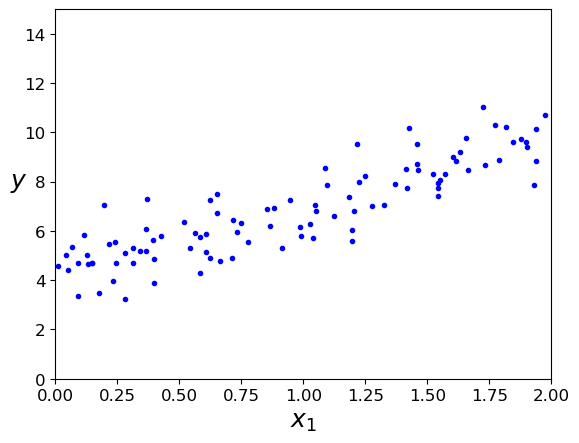

In [3]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
plt.show()

그럼 이제 정규방정식을 사용해 $\hat{\theta}$을 계산해보겠습니다. 넘파이 선형대수 모듈(`np.linalg`)에 있는 `inv()` 함수를 사용해 역행렬을 계산하고 `dot()` 메서드를 사용해 행렬 곱셈을 하겠습니다.

$$ \hat{\theta}=(\mathbf{X}^T\mathbf{X})^{－1}\mathbf{X}^T\mathbf{y} $$

In [4]:
X_b = np.c_[np.ones((100, 1)), X]  # 모든 샘플에 x0 = 1을 추가합니다.
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

이 데이터를 생성하기 위해 사용한 함수는 $y = 4 ＋ 3\mathbf{x}_1 ＋ 가우시안\_잡음$입니다. 정규방정식으로 계산한 값을 확인해보겠습니다.

In [5]:
theta_best

array([[4.21509616],
       [2.77011339]])

$\theta_0 = 4.214$와 $\theta_1=2.770$ 대신 $\theta_0=4$와 $\theta_1=3$을 기대했었습니다. 매우 비슷하지만 잡음 때문에 원래 함수의 파라미터를 정확하게 재현하지 못했습니다.

$\hat{\theta}$을 사용해 예측을 해보겠습니다.

$$ \hat{y}=\mathbf{X}\hat{\theta} $$

In [6]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]  # 모든 샘플에 x0 = 1을 추가합니다.
y_predict = X_new_b.dot(theta_best)
y_predict

array([[4.21509616],
       [9.75532293]])

모델의 예측을 그래프로 나타내보겠습니다.

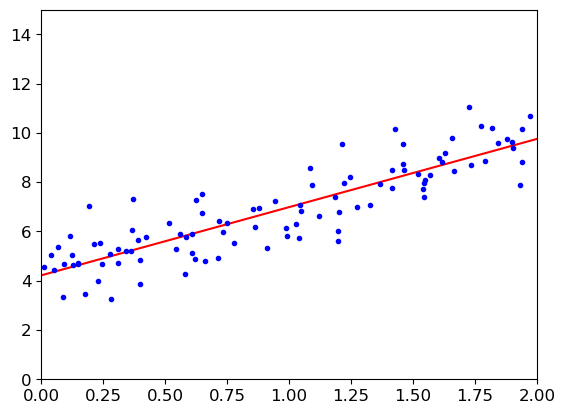

In [7]:
plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, "b.")
plt.axis([0, 2, 0, 15])
plt.show()

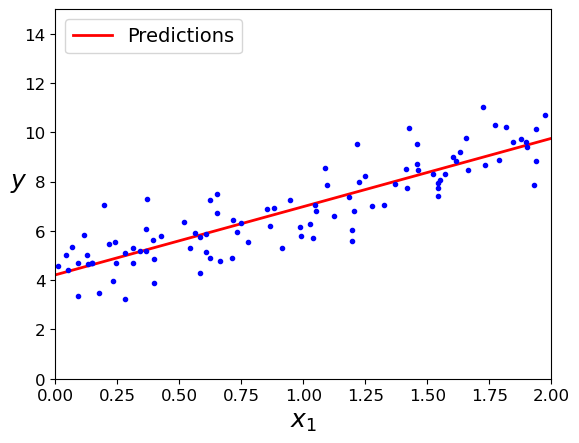

In [8]:
plt.plot(X_new, y_predict, "r-", linewidth=2, label="Predictions")
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 2, 0, 15])
plt.show()

사이킷런에서 선형 회귀를 수행하는 것은 간단합니다.\*

---

\* 사이킷런은 특성의 가중치(coef_)와 편향(intercept_)을 분리하여 저장합니다.

In [9]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.21509616]), array([[2.77011339]]))

In [10]:
lin_reg.predict(X_new)

array([[4.21509616],
       [9.75532293]])

`LinearRegression` 클래스는 `scipy.linalg.lstsq()` 함수('최소 제곱$^{least \ squares}$'에서 이름을 따왔습니다)를 기반으로 합니다. 이 함수를 직접 호출할 수 있습니다.

In [11]:
# 싸이파이 lstsq() 함수를 사용하려면 scipy.linalg.lstsq(X_b, y)와 같이 씁니다.
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[4.21509616],
       [2.77011339]])

이 함수는 $\hat{\theta}=\mathbf{X}^＋\mathbf{y}$을 계산합니다. 여기에서 $\mathbf{X}^＋$는 $\mathbf{X}$의 <span style="color: #008000">유사역행렬</span>$^{pseudo \ inverse}$입니다(정확하게는 무어－펜로즈$^{Moore－Penrose}$ 역행렬입니다). `np.linalg.pinv()` 함수를 사용해 유사역행렬을 직접 구할 수 있습니다.

In [12]:
np.linalg.pinv(X_b).dot(y)

array([[4.21509616],
       [2.77011339]])

유사역행렬 자체는 <span style="color: #008000">특잇값 분해</span>$^{singular \ value \ decomposition}$(SVD)라 부르는 표준 행렬 분해 기법을 사용해 계산됩니다. SVD는 훈련 세트 행렬 $\mathbf{X}$를 3개의 행렬 곱셈 $\mathbf{U \Sigma V}^T$로 분해합니다(`numpy.linalg.svd()`를 참고하세요). 유사역행렬은 $\mathbf{X}^＋=\mathbf{V\Sigma^＋ U}^T$로 계산됩니다. $\mathbf{\Sigma^＋}$를 계산하기 위해 알고리즘이 $\mathbf{\Sigma}$를 먼저 구하고 그다음 어떤 낮은 임곗값보다 작은 모든 수를 0으로 바꿉니다. 그다음 0이 아닌 모든 값을 역수로 치환합니다. 마지막으로 만들어진 행렬을 전치합니다. 정규방정식을 계산하는 것보다 이 방식이 훨씬 효율적입니다. 또한 극단적인 경우도 처리할 수 있습니다. 실제로 $m \ < \ n$이거나 어떤 특성이 중복되어 행렬 $\mathbf{X}^T\mathbf{X}$의 역행렬이 없다면(즉, 특이 행렬이라면) 정규방정식이 작동하지 않습니다. 하지만 유사역행렬은 항상 구할 수 있습니다.

### 4.1.2 계산 복잡도

정규방정식은 $(n ＋ 1) × (n ＋ 1)$ 크기가 되는 $\mathbf{X}^T\mathbf{X}$의 역핼렬을 계산합니다($n$은 특성 수). 역행렬을 계산하는 <span style="color: #008000">계산 복잡도</span>$^{computational \ complexity}$는 일반적으로 $O(n^{2.4}$에서 $O(n^3)$ 사이입니다(구현 방법에 따라 차이가 있습니다). 다시 말해 특성 수가 두 배로 늘어나면 계산 시간이 대략 $2^{2.4} = 5.3$에서 $2^3=8$배로 증가합니다.

사이킷런의 `LinearRegression` 클래스가 사용하는 SVD 방법은 약 $O(n^2)$입니다. 특성의 개수가 두 배로 늘어나면 계산 시간이 대략 4배가 됩니다.

<span style="color: #FFA500">CAUTION_</span> 정규방정식과 SVD 방법 모두 특성 수가 많아지면 (예를 들어 100,000) 매우 느려집니다. 다행인 것은 훈련 세트의 샘플 수에 대해서는 선형적으로 증가합니다(둘 다 $O(m)$입니다).\* 따라서 메모리 공간이 허락된다면 큰 훈련 세트들도 효율적으로 처리할 수 있습니다.

---

\* $\mathbf{X}$를 (샘플 수, 특성 수)인 $m×n$ 행렬이라 할 때 $\mathbf{X}^T\mathbf{X}$는 $(n×m)(m×n)=(n×n)$ 크기의 행렬이 되므로 샘플 수($m$)가 역행렬의 복잡도를 증가시키지 않고 점곱의 양만 선형적으로 증가시킵니다.

또한 (정규방정식이나 다른 알고리즘으로) 학습된 선형 회귀 모델은 예측이 매우 빠릅니다. 예측 계산 복잡도는 샘플 수와 특성 수에 선형적입니다. 다시 말해 예측하려는 샘플이 두 배로 늘어나면(또는 측성이 두 배로 늘어나면) 걸리는 시간도 거의 두 배 증가합니다.

이제 아주 다른 방법으로 선형 회귀 모델을 훈련시켜보겠습니다. 이 방법은 특성이 매우 많고 훈련 샘플이 너무 많아 메모리에 모두 담을 수 없을 때 적합합니다.

## 4.2 경사 하강법

<span style="color: #008000">경사 하강법</span>$^{gradient \ descent}$(GD)은 여러 종류의 문제에서 최적의 해법을 찾을 수 있는 일반적인 최적화 알고리즘입니다. 경사 하강법의 기본 아이디어는 비용 함수를 최소화하기 위해 반복해서 파라미터를 조정해가는 것입니다.

짙은 안개 때문에 산속에서 길을 잃었다고 생각해보세요. 발밑 지면의 기울기만 느낄 수 있습니다. 빨리 골짜기로 내려가는 좋은 방법은 가장 가파른 길을 따라 아래로 내려가는 것입니다. 이것이 바로 경가 하강법의 원리입니다. 파라미터 벡터 $\mathbf{\theta}$에 대해 비용 함수의 현재 그레이디언트$^{gredient}$를 계산합니다.\* 그리고 그레이디언트가 감소하는 방향으로 진행합니다. 그레이디언트가 0이 되면 최솟값에 도달한 것입니다!

구체적으로 보면 $\mathbf{\theta}$를 임의의 값으로 시작해서(<span style="color: #008000">무작위 초기화</span>$^{random \ initialization}$라고 합니다) 한 번에 조금씩 비용 함수(예를 들면 MSE)가 감소되는 방향으로 진행하여 알고리즘이 최솟값에 수렴할 때까지 점진적으로 향상시킵니다.

경사 하강법에서 중요한 파라미터는 스텝\*\*의 크기로, <span style="color: #008000">학습률</span>$^{learning \ rate}$ 하이퍼파라미터로 결정됩니다. 학습률이 너무 작으면 알고리즘이 수렴하기 위해 반복을 많이 진행해야 하므로 시간이 오래 걸립니다.

한편 학습률이 너무 크면 골짜기를 가로질러 반대편으로 건너뛰게 되어 이전보다 더 높은 곳으로 올라가게 될지도 모릅니다. 이는 알고리즘을 더 큰 값으로 발산하게 만들어 적절한 해법을 찾기 못하게 합니다.

모든 비용 함수가 매끈한 그릇과 같지는 않습니다. 패인 곳, 산마루, 평지 등 특이한 지형이 있으면 최솟값으로 수렴하기 매우 어렵습니다. 무작위 초기화 때문에 알고리즘이 왼쪽에서 시작하면 <span style="color: #008000">전역 최솟값</span>$^{global \ minimum}$보다 덜 좋은 <span style="color: #008000">지역 최솟값</span>$^{local \ minimum}$에 수렴합니다. 알고리즘이 오른쪽에서 시작하면 평탄한 지역을 지나기 위해 시간이 오래 걸리고 일찍 멈추게 되어 전역 최솟값에 도달하지 못합니다.

다행히 선형 회귀를 위한 MSE 비용 함수는 곡선에서 어떤 두 점을 선택해 선을 그러도 곡선을 가로지르지 않는 <span style="color: #008000">볼록 함수</span>$^{convex \ function}$입니다.\*\*\* 이는 지역 최솟값이 없고 하나의 전역 최솟값만 있다는 뜻입니다. 또한 역속된 함수이고 기울기가 갑자기 변하지 않습니다. \*\*\*\* 이 두 사실로부터 경사 하강법이 전역 최솟값에 가깝게 접근할 수 있다는 것을 보장합니다(학습률이 너무 높지 않고 충분한 시간이 주어지면).

사실 비용 함수는 그릇 모양을 하고 있지만 특성들의 스케일이 매우 다르면 길쭉한 모양일 수 있습니다. 

---

\* 원문에 있는 slope는 기울기로 번역하고 gradient는 비용 함수의 미분값이란 의미로 포괄적으로 사용되므로 그냥 그레이디언트라고 번역했습니다. 번역서에서는 외래어 표기법에 따라 '그레이디언트'라고 쓰지만 일반적으로 '그래디언트'라고 부릅니다. 인터넷 검색엔진을 사용할 때 참고하세요.  
\*\* 반복적인 학습 알고리즘에서 학습의 각 단계를 표현할 때 일반적인 단어의 의미와 구분하기 위해 원문 그대로 스텝(step)이라고 옮겼습니다.  
\*\*\* 두 점을 이른 선분이 두 점 사이에서 항상 곡선 위에 위치할 경우를 볼록 함수, 아래에 위치할 경우 오목 함수라고 합니다.  
\*\*\*\* 기술적으로 말하면 이 함수의 도함수가 <span style="color: #008000">립시츠 연속</span>($^{Lipschitz \ continuous}$)입니다. 어떤 함수의 도함수가 일정한 범위 안에서 변할 때 이 함수를 립시츠 연속 함수라고 합니다. 예를 들어 $sin(x)$는 립시츠 연속 함수지만 $\sqrt{x}$는 $x=0$일 때 기울기가 무한대가 되므로 립시츠 연속함수가 아닙니다. MSE는 $x$가 무한대일 때 기울기가 무한대가 되므로 국부적인(locally) 립시츠 함수라고 합니다. 이 이름은 독일의 수학자 루돌프 립시츠(Rudolf Lipschitz)에서 따왔습니다.

<span style="color: #FFA500">CAUTION_</span> 경사 하상법을 사용할 때는 반드시 모든 특성이 같은 스케일을 갖도록 만들어야 합니다(예를 들면 사이킷런의 `StandardScaler`\*를 사용하여). 그렇지 않으면 수렴하는 데 훨씬 오래 걸립니다.

---

\* `StandardScaler`는 데이터의 각 특성에서 평균을 빼고 표준편차로 나누어 평균을 0으로, 분산을 1로 만듭니다.

앞의 내용은 모델 훈련이 (훈련 세트에서) 비용 함수를 최소화하는 모델 파라미터의 조합을 찾는 일임을 설명해줍니다. 이를 모델의 <span style="color: #008000">파라미터 공간</span>$^{parameter \ space}$에서 찾는다고 말합니다. 모델이 가진 파라미터가 많을수록 이 공간의 차원은 커지고 검색이 더 어려워집니다. 300차원의 건초더미에서 바늘을 찾는 것은 차원이 3개뿐일 때보다 훨씬 어렵습니다. 다행히 선형 회귀의 경우 비용 함수가 볼록 함수이기 때문에 이 바늘은 그릇의 맨 아래에 있을 것입니다.

### 4.2.1 배치 경사 하강법

경사 하강법을 구현하려면 각 모델 파라미터 $\theta_j$에 대해 비용 함수의 그레이디언트를 계산해야 합니다. 다시 말해 $\theta_j$가 조금 변경될 때 비용 함수가 얼마나 바뀌는지 계산해야 합니다. 이를 <span style="color: #008000">편도함수</span>$^{partial \ derivative}$라고 합니다. 이는 '동쪽을 바라봤을 때 발밑에 느껴지는 산의 기울기는 얼마인가?'와 같은 질문입니다. 그리고 같은 질문을 북쪽에 대해서도 합니다(3차원 이상의 세상이라 가정하면 다른 모든 차원에 대해서도 반복합니다). 다음 식\*은 파라미터 $\theta_j$에 대한 비용 함수의 편도함수 $\frac{\partial}{\partial\theta_j}MSE(\theta)$입니다.

$$ \frac{\partial}{\partial\theta_j}MSE(\theta)=\frac{2}{m}\sum_{i=1}^m(\theta^T\mathbf{x}^{(i)} － y^{(i)})x_j^{(i)} $$

편도함수를 각각 계산하는 대신 아래 식을 사용하여 한꺼번에 계산할 수 있습니다. 그레이디언트 벡터 $ \nabla_{\theta}MSE(\theta)$는 비용 함수의 (모델 파라미터마다 한 개씩인) 편도함수를 모두 담고 있습니다.\*\*

$$ \nabla_{\theta}MSE(\theta) = \left( \begin{array}{cc} \frac{\partial}{\partial\theta_0}MSE(\theta) \\
\frac{\partial}{\partial\theta_1}MSE(\theta) \\
\vdots \\
\frac{\partial}{\partial\theta_n}MSE(\theta) \\
\end{array} \right) = \frac{2}{m}\mathbf{X}^T(\mathbf{X}\theta－y) $$

---

\* 선형 회귀 모델의 MSE 비용 함수의 MSE 공식을 $\theta_j$에 대해 편미분하면 미분 공식에 따라 지수가 곱셈으로 내려오고 괄호 안의 편미분이 추가로 곱해집니다. $\theta_j$에 대해 미분하므로 $\theta$의 나머지 파라미터 항은 상수로 취급되고 $x_j$만 곱해집니다. 곱하기 2는 다음에 나오는 식의 학습률 $\eta$에 포함시켜 생각할 수 있어서 종종 비용 함수에 1／2을 곱한 다음 편도함수에서는 2를 빼고 간단하게 표현하기도 합니다.  

\** 위 식과 같이 행렬의 점곱으로 표현하면 곱셈 순서가 바뀌는 경우가 많습니다. $\mathbf{X}$는 샘플 수 $m$, 특성 수 $n$인 $m × n$ 행렬이므로 $n$개의 파라미터를 가진 $n × 1$ 벡터 $\theta$와 곱해서 $m × 1$벡터를 만듭니다. 같은 크기의 $y$ 벡터를 빼고 $\mathbf{X}$ 자기 자신과 곱셈을 위해 $\mathbf{X}$ 행렬을 전치시켜 $n × m$ 행렬로 바꿔 곱합니다. 결국 최종 계산 결과는 파라미터 수와 같은 $n × 1$ 벡터가 됩니다.

<span style="color: #FFA500">CAUTION_</span> 이 공식은 매 경사 하강법 스텝에서 전체 훈련 세트 $\mathbf{X}$에 대해 계산합니다! 그래서 이 알고리즘을 <span style="color: #008000">배치 경사 하강법</span>$^{batch \ gradient \ descent}$이라고 합니다. 즉, 매 스텝에서 훈련 데이터 전체를 사용합니다(사실 전체 경사 하강법$^{full \ gradient \ descent}$이 더 적절한 이름 같습니다). 이런 이유로 매우 큰 훈련 세트에서는 아주 느립니다(잠시 후에 훨씬 빠른 경사 하강법의 알고리즘을 볼 것입니다). 그러나 경사 하강법은 특성 수에 민감하지 않습니다. 수십만 개의 특성에서 선형 회귀를 훈련시키려면 정규방정식이나 SVD 분해보다 경사 하강법을 사용하는 편이 훨씬 빠릅니다.

위로 향하는 그레이디언트 벡터가 구해지면 반대 방향인 아래로 가야 합니다. $\theta$에서 $\nabla_\theta MSE(\theta)$를 빼야 한다는 뜻입니다. 여기서 학습률 $\eta$가 사용됩니다.\* 내려가는 스텝의 크기를 결정하기 위해 그레이디언트 벡터에 $\eta$를 곱합니다.

$$ \theta^{(next \ step)} = \theta － \eta\nabla_\theta MSE(\theta) $$

이 알고리즘을 간단히 구현해보겠습니다.

---

\* 에타($\eta$)는 일곱 번째 그리스 문자입니다.

In [13]:
eta = 0.1  # 학습률
n_iterations = 1000
m = 100

theta = np.random.randn(2,1)  # 랜덤 초기화

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients

아주 어렵지는 않네요! 계산된 `theta`를 확인해보겠습니다.

In [14]:
theta

array([[4.21509616],
       [2.77011339]])

정규방정식으로 찾은 것과 정확히 같군요! 경사 하강법이 완벽하게 작동했습니다. 학습률 $\eta$를 바꿔보면 어떨까요? 다음 그림은 세 가지 다른 학습률을 사용하여 진행한 경사 하강법의 스텝 처음 10개를 보여줍니다(점선은 시작점을 나타냅니다).

In [15]:
X_new_b.dot(theta)

array([[4.21509616],
       [9.75532293]])

In [16]:
theta_path_bgd = []

def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_iterations = 1000
    for iteration in range(n_iterations):
        if iteration < 10:
            y_predict = X_new_b.dot(theta)
            style = "b-" if iteration > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients
        if theta_path is not None:
            theta_path.append(theta)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 2, 0, 15])
    plt.title(r"$\eta = {}$".format(eta), fontsize=16)

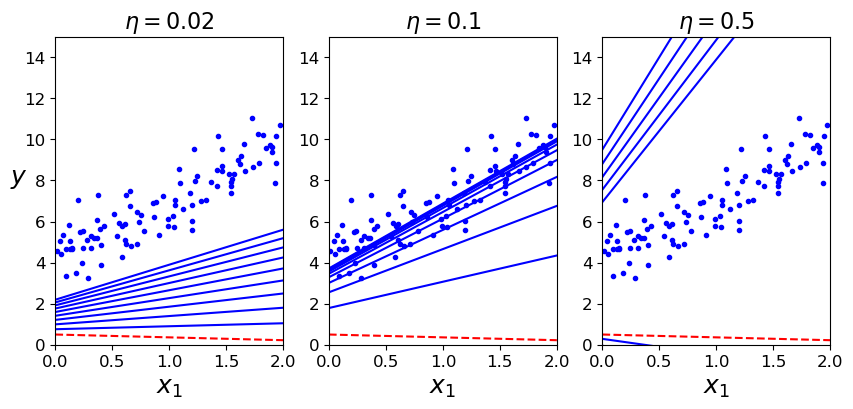

In [17]:
np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

plt.figure(figsize=(10,4))
plt.subplot(131); plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(132); plot_gradient_descent(theta, eta=0.1, theta_path=theta_path_bgd)
plt.subplot(133); plot_gradient_descent(theta, eta=0.5)

plt.show()

왼쪽은 학습률이 너무 낮습니다. 알고리즘은 최적점에 도달하겠지만 시간이 오래 걸릴 것입니다. 가운데는 학습률이 아주 적당해 보입니다. 반복 몇 번 만에 이미 최적점에 수렴했습니다. 오른쪽은 학습률이 너무 높습니다. 알고리즘이 이리저리 널뛰면서 스텝마다 최적점에서 점점 더 멀어져 발산합니다.

적절한 학습률을 찾으려면 그리드 탐색을 사용합니다(2장 참조). 하지만 그리드 탐색에서 수렴하는 데 너무 오래 걸리는 모델을 막기 위해 반복 횟수를 제한해야 합니다.

반복 횟수는 어떻게 지정할까요? 너무 작으면 최적점에 도달하기 전에 알고리즘이 멈춥니다. 너무 크면 모델 파라미터가 더는 변하지 않는 동안 시간을 낭비하게 됩니다. 간단한 해결책은 반복 횟수를 아주 크게 지정하고 그레이디언트 벡터가 아주 작아지면, 즉 벡터의 노름이 어떤 값 $\varepsilon$(<span style="color: #008000">허용오차</span>$^{tolerance}$)보다 작아지면 경사 하강법이 (거의) 최솟값에 도달한 것으로 알고리즘을 중지하는 것입니다.

**수렴율**

비용 함수가 볼록 함수이고 기울기가 급격하게 바뀌지 않는 경우(MSE 비용 함수 같은), 학습률을 고정한 배치 경사 하강법은 어느 정도 시간이 걸리겠지만 결국 최적의 솔루션에 수렴할 것입니다. 비용 함수의 모양에 따라 달라지겠지만 $\varepsilon$ 범위 안에서 최적의 솔루션에 도달하기 위해서는 $O(1／\varepsilon)$의 <span style="color: #008000">반복</span>이 걸릴 수 있습니다. 다시 말해 (더 정확한 최솟값을 얻기 위해) 허용 오차를 $\varepsilon$을 1／10로 줄이면 알고리즘의 반복은 10배 늘어날 것입니다.

### 4.2.2 확률적 경사 하강법

배치 경사 하강법의 가장 큰 문제는 매 스텝에서 전체 훈련 세트를 사용해 그레이디언트를 계산한다는 사실입니다. 훈련 세트가 매우 커지면 매우 느려지게 됩니다. 이와는 정반대로 <span style="color: #008000">확률적 경사 하강법</span>은 매 스텝에서 한 개의 샘플을 무작위로 선책하고 그 하나의 샘플에 대한 그레이디언트를 계산합니다. 매 반복에서 다뤄야 할 데이터가 매우 적기 때문에 한 번에 하나의 샘플을 처리하면 알고리즘이 확실히 훨씬 빠릅니다. 또한 매 반복에서 하나의 샘플만 메모리에 있으면 되므로 매우 큰 훈련 세트도 훈련시킬 수 있습니다(SGD는 외부 메모리 학습 알고리즘으로 구현할 수 있습니다. 1장을 참조하세요).

반면 확률적(즉, 무작위)이므로 이 알고리즘은 배치 경사 하강법보다 훨씬 불안정합니다. 비용 함수가 최댓값에 다다를 때까지 부드럽게 감소하지 않고 위아래로 요동치며 평균적으로 감소합니다. 시간이 지나면 최솟값에 매우 근접하겠지만 요동이 지속되면서 최솟값에 안착하지 못할 것입니다. 알고리즘이 멈출 때 조은 파라미터가 구해지겠지만 최적치는 아닙니다.

비용 함수가 매우 불규칙할 때 알고리즘이 지역 최솟값을 건너뛰도록 도와주므로 확률적 경사 하강법이 배치 경사 하강법보다 전역 최솟값을 찾을 가능성이 높습니다.

무작위성은 지역 최솟값에서 탈출시켜줘서 좋지만 알고리즘을 전역 최솟값에 다다르지 못하게 한다는 점에서는 좋지 않습니다. 이 딜레마를 해결하는 한 가지 방법은 학습률을 점진적으로 감소시키는 것입니다. 시작할 때는 학습률을 크게 하고(수렴을 빠르게하고 지역 최솟값에 빠지지 않게 합니다), 점차 작게 줄여서 알고리즘이 전역 최솟값에 도달하게 합니다. 이 과정은 금속공학 분야에서 가열한 금속을 천천히 냉각시키는 어닐링$^{annealing}$(풀림) 과정에서 영감을 얻은 <span style="color: #008000">담금질 기법</span>$^{simulated \ annealing}$ 알고리즘과 유사합니다. 매 반복에서 학습률을 결정하는 함수를 <span style="color: #008000">학습 스케줄</span>$^{learning \ schedule}$\*이라고 부릅니다. 학습률이 너무 빨리 줄어들면 지역 최솟값에 갇히거나 최솟값까지 가는 중간에 멈춰버릴 수도 있습니다. 학습률이 너무 천천히 줄어들면 오랫동안 최솟값 주변을 맴돌거나 훈련을 너무 일찍 중지해서 지역 최솟값에 머무를 수 있습니다.

다음 코드는 간단한 학습 스케줄을 사용한 확률적 경사 하강법의 구현입니다.

---

\* 학습률 스케줄(learning rate schedule)이라고도 합니다.

In [18]:
theta_path_sgd = []
m = len(X_b)
np.random.seed(42)

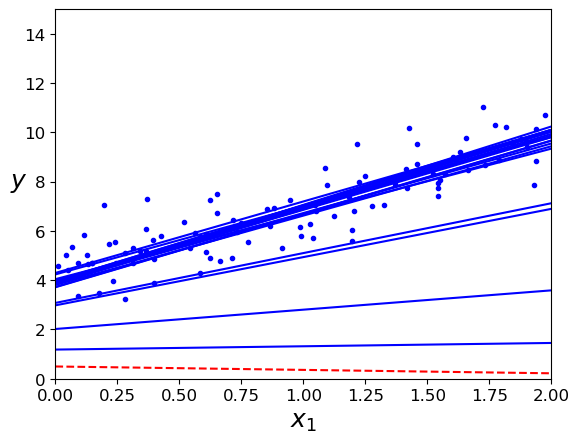

In [19]:
n_epochs = 50
t0, t1 = 5, 50  # 학습 스케줄 하이퍼파라미터

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2,1)  # 랜덤 초기화

for epoch in range(n_epochs):
    for i in range(m):
        if epoch == 0 and i < 20:
            y_predict = X_new_b.dot(theta)
            style = "b-" if i > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
        theta_path_sgd.append(theta)

plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
plt.show()

일반적으로 한 반복에서 $m$번\* 되풀이 되고, 이때 각 반복을 <span style="color: #008000">에포크</span>$^{epoch}$라고 합니다. 배치 경사 하강법 코드가 전체 훈련 세트에 대해 1,000번 반복하는 동안 이 코드는 훈련 세트에서 50번만 반복하고도 매우 좋은 값에 도달했습니다.

---

\* $m$은 훈련 세트에 있는 샘플 수입니다.

In [20]:
theta

array([[4.21076011],
       [2.74856079]])

위 그림은 훈련 스텝의 첫 20개를 보여줍니다(스텝이 불규칙하게 진행합니다).

샘플을 무작위로 선택하기 때문에 어떤 샘플은 한 에포크에서 여러 번 선택될 수 있고 어떤 샘플은 전혀 선택되지 못할 수도 있습니다. 알고리즘에 에포크마다 모든 샘플을 사용하게 하려면 훈련 세트를 섞은 후 (입력 특성과 레이블을 동일하게 섞어야 합니다) 차례대로 하나씩 선택하고 다음 에포크에서 다시 섞는 식의 방법을 사용할 수 있습니다.\* 그러나 이렇게 하면 보통 더 늦게 수렴됩니다.

---

\* 사이킷런의 `SGDClassifier`와 `SGDRegressor`가 사용하는 방법입니다.

<span style="color: #FFA500">CAUTION_</span> 확률적 경사 하강법을 사용할 때 훈련 샘플이 IID$^{independent \ and \ identically \ distributed}$를 만족해야 평균적으로 파라미터가 전역 최적점을 향해 진행한다고 보장할 수 있습니다. 이렇게 만드는 간단한 방법은 훈련하는 동안 샘플을 섞는 것입니다(예를 들어, 각 샘플을 랜덤하게 선택하거나 에포크를 시작할 때 훈련 세트를 섞습니다). 만약 레이블 순서대로 정렬된 샘플처럼 샘플을 섞지 않은 채로 사용하면 확률적 경사하강법이 먼저 한 레이블에 최적화하고 그다음 두 번째 레이블을 최적화하는 식으로 진행됩니다. 결국 이 모델은 최적점에 가깝게 도달하지 못할 것입니다.

사이킷런에서 SGD 방식으로 선형 회귀를 사용하려면 기본값으로 제곱 오차 비용 함수를 최적화하는 `SGDRegressor` 클래스를 사용합니다. 다음 코드는 최대 1,000번 에포크 동안 실행됩니다(`max_iter=1000`). 또한 한 에포크에서 0.001보다 적게 손실이 줄어들 때까지 실행됩니다(`tol=1e-3`). 학습률 0.1(`eta0=0.1`)로 기본 학습 스케줄(이전과는 다른\*)을 사용합니다. 규제는 전혀 사용하지 않았습니다(`penalty=None`, 이에 대해서는 곧 자세히 다룹니다).

---

\* `SGDRegressor`에서 학습 스케줄을 의미하는 매개변수 `learning_rate`의 기본값은 '`invscaling`'으로, 반복 횟수 $t$와 `eta0`, `power_t` 두 매개변수(기본값은 각각 0.01, 0.25)를 사용한 다음 공식으로 학습률을 계산합니다.  
$$ \eta^{(t)} = \frac{eta0}{t^{power\_t}} $$  
`SGDClassifier`의 `learning_rate` 기본값은'`optimal`'로 다음 공식을 사용합니다.  
$$ \eta^{(t)} = \frac{1}{alpha(t_0＋t)} $$  
여기서 $t_0$는 페이스북 머신러닝 연구원인 레옹 보투(Léon Bottou)가 제안한 값으로, `alpha` 매개변수와 비용 함수에 따라 결정됩니다.

In [21]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1, random_state=42)
sgd_reg.fit(X, y.ravel())

SGDRegressor(eta0=0.1, penalty=None, random_state=42)

여기에서도 정규방정식으로 구한 것과 매우 비슷한 값을 얻었습니다.

In [22]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.24365286]), array([2.8250878]))

### 4.2.3 미니배치 경사 하강법

마지막으로 볼 경사 하강법 알고리즘은 <span style="color: #008000">미니배치 경사 하강법</span>$^{mini-batch \ gradient \ descent}$입니다. 배치와 확률적 경사 하강법을 알고 있다면 이해하기 매우 쉽습니다. 각 스텝에서 전체 훈련 세트(배치 경사 하강법에서처럼)나 하나의 샘플(확률적 경사 하강법에서처럼)을 기반으로 그레이디언트를 계산하는 것이 아니라 <span style="color: #008000">미니배치</span>라 부르는 임의의 작은 샘플 세트에 대해 그레이디언트를 계산합니다. 확률적 경사 하강법에 비해 미니배치 경사 하강법의 주요 장점은 행렬 연산에 최적화된 하드웨어, 특히 GPU를 사용해서 얻는 성능 향상입니다.

특히 미니배치를 어느 정도 크게 하면 이 알고리즘은 파라미터 공간에서 `SGD`보다 덜 불규칙하게 움직입니다. 결국 미니배치 경사 하강법이 `SGD`보다 최솟값에 더 가까이 도달하게 될 것입니다. 하지만 지역 최솟값에서 빠져나오기는 더 힘들지도 모릅니다(선형 회귀와 같지 않고 지역 최솟값이 문제가 되는 경우). 아래 그림은 세 가지 경사 하강법 알고리즘이 훈련 과정 동안 파라미터 공간에서 움직인 경로입니다. 모두 최솟값 근처에 도달했지만 배치 경사 하강법의 경로가 실제로 최솟값에서 멈춘 반면 확률적 경사 하강법과 미니배치 경사 하강법은 근처에서 맴돌고 있습니다. 그렇지만 배치 경사 하강법에는 매 스텝에서 많은 시간이 소요되고, 확률적 경사 하강법과 미니배치 경사 하강법도 적절한 학습 스케줄을 사용하면 최솟값에 도달한다는 것을 잊지 말아야 합니다.

In [23]:
theta_path_mgd = []

n_iterations = 50
minibatch_size = 20

np.random.seed(42)
theta = np.random.randn(2,1)  # 랜덤 초기화

t0, t1 = 200, 1000
def learning_schedule(t):
    return t0 / (t + t1)

t = 0
for epoch in range(n_iterations):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for i in range(0, m, minibatch_size):
        t += 1
        xi = X_b_shuffled[i:i+minibatch_size]
        yi = y_shuffled[i:i+minibatch_size]
        gradients = 2/minibatch_size * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(t)
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)

In [24]:
theta

array([[4.25214635],
       [2.7896408 ]])

In [25]:
theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

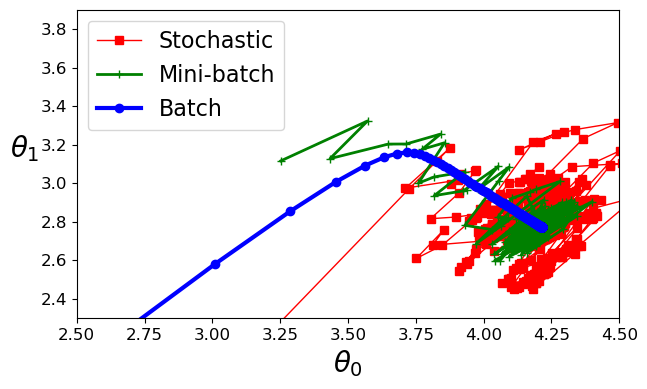

In [26]:
plt.figure(figsize=(7,4))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1, label="Stochastic")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=2, label="Mini-batch")
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=3, label="Batch")
plt.legend(loc="upper left", fontsize=16)
plt.xlabel(r"$\theta_0$", fontsize=20)
plt.ylabel(r"$\theta_1$   ", fontsize=20, rotation=0)
plt.axis([2.5, 4.5, 2.3, 3.9])
plt.show()

지금까지 논의한 알고리즘을 선형 회귀\*를 사용해 비교해보겠습니다($m$은 훈련 샘플 수 이고 $n$은 특성 수입니다). 다음 표(선형 회귀를 사용한 알고리즘 비교\*\*)를 참조하세요.

---

\* 정규 방정식은 선형 회귀만을 위한 알고리즘이지만 경사 하강법 알고리즘은 앞으로 보게 될 여러 가지 다른 모델도 훈련시킬 수 있습니다.  
\*\* 사이킷런의 `SGDRegressor`와 `SGDClassifier`에서 `partial_fit` 메서드를 사용하여 모델 파라미터를 초기화하지 않고 미니배치 학습을 위해 반복적으로 호출할 수 있습니다. 하지만 `partial_fit` 메서드는 `fit` 메서드와 동일하게 미니배치의 샘플을 하나씩 적용하므로 엄밀히 말하면 미니배치 경사하강법 알고리즘은 아닙니다.

$$ \begin{array}{cc}
알고리즘 & m이 클 때 \ \ \ & 외부 메모리 학습 지원 & n이 클 때 \ \ \ & 하이퍼파라미터 수 & 스케일 조정 필요 & 사이킷런 \\
정규방정식 & 빠름 & No & 느림 & 0 & No & N／A \\
SVD & 빠름 & No & 느림 & 0 & No & LinearRegression \\
배치 경사 하강법 & 느림 & No & 빠름 & 2 & Yes & SGDRegressor \\
확률적 경사 하강법 & 빠름 & Yes & 빠름 & \geq2 & Yes & SGDRegressor \\
미니배치 경사 하강법 & 빠름 & Yes & 빠름 & \geq2 & Yes & SGDRegressor \\
\end{array}
$$

<span style="color: #008000">NOTE_</span> 이 알고리즘들은 훈련 결과에 거의 차이가 없습니다. 모두 매우 비슷한 모델을 만들고 정확히 같은 방식으로 예측을 합니다.

## 4.3 다항 회귀

가지고 있는 데이터가 단순한 직선보다 복잡한 형태라면 어떨까요? 신기하게도 비선형 데이터를 학습하는 데 선형 모델을 사용할 수 있습니다. 이렇게 하는 간단한 방법은 각 특성의 거듭제곱을 새로운 특성으로 추가하고, 이 확장된 특성을 포함한 데이터셋에 선형 모델을 훈련시키는 것입니다. 이런 기법을 <span style="color: #008000">다항 회귀</span>$^{polynomial \ regression}$라고 합니다.

예를 들어보겠습니다. 먼저 간단한 <span style="color: #008000">2차방정식</span>$^{quadratic \ equation}$\*으로 비선형 데이터를 생성하겠습니다(약간의 잡을을 포함합니다. 아래 그림을 참조하세요).

---

\* 2차방정식의 형식은 $y=ax^2＋bx＋c$입니다.

In [27]:
import numpy as np
import numpy.random as rnd

np.random.seed(42)

In [28]:
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

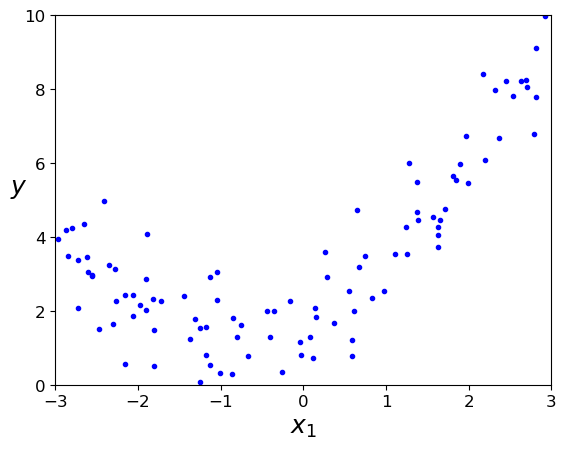

In [29]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
plt.show()

확실히 직선은 이 데이터에 잘 맞지 않을 것입니다. 그러므로 사이킷런의 `PolynomialDeatures`를 사용해 훈련 데이터를 변환해보겠습니다.\* 훈련 세트에 있는 각 특성을 제곱(2차 다항)하여 새로운 특성으로 추가합니다(여기서는 특성 하나가 추가됩니다).

---

\* `PolynomialFeatures`의 매개변수 `degree`의 기본값을 2이고 `include_bias`의 기본값을 `True`입니다. `include_bias=True`면 편향을 위한 측성($x_0$)인 1이 추가됩니다.

In [30]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0]

array([-0.75275929])

In [31]:
X_poly[0]

array([-0.75275929,  0.56664654])

`X_ploy`는 이제 원해 특성`X`와 이 특성의 제곱을 포함합니다. 이 확장된 훈련 데이터에 `KinearRegression`을 적용해보겠습니다.

In [32]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.78134581]), array([[0.93366893, 0.56456263]]))

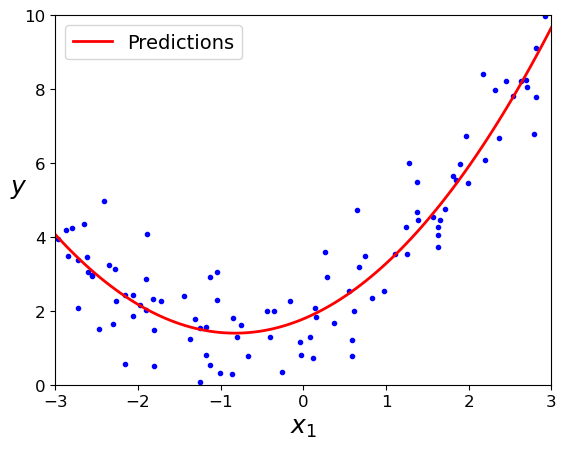

In [33]:
X_new=np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-3, 3, 0, 10])
plt.show()

나쁘지 않네요. 실제 원래 함수가 $y=0.5x_1^2＋1.0x_1＋2.0＋가우시안 \ 잡음$이고 예측된 모델은 $\hat{y}=0.56x_1^2＋0.93x_1＋1.78$입니다.

특성이 여러 개일 때 다항 회귀는 이 특성 사이의 관계를 찾을 수 있습니다(일반적인 선형 회귀 모델에서는 하지 못합니다). `PolynomialFeatures`가 주어진 차수까지 특성 간의 모든 교차항을 추가하기 때문입니다. 예를 들어 두 개의 측성 $a$, $b$가 있을 때 `degree=3`으로 `PolynomialFeatures`를 적용하면 $a^2$, $a^3$, $b^2$, $b^3$뿐만 아니라 $ab$, $A^2b$, $ab^2$도 특성으로 추가합니다.\*

---

\* `PolynomialFeatures`에서 `interaction_only=True`로 지정하면 거듭제곱이 포함된 항은 모두 제외됩니다. 즉 $a$, $b$, $ab$만 남습니다. `PolynomialFeatures`의 객체에서 `get_feature_names_out()` 메서드를 호출하면 만들어진 특성의 차수를 쉽게 확인할 수 있습니다.

<span style="color: #FFA500">CAUTION_</span> `PolynomialFeatures(degree=d)`는 특성이 $n$개인 배열을 특성이 $\frac{(n ＋ d)!}{d! n!}$개인 별로 변환합니다.\* 여기서 $n!$은 $n$의 <span style="color: #008000">팩토리얼</span>로 $1×2×3×\cdots×n$과 같습니다. 특성 수가 교차항을 포함해 엄청나게 늘어날 수 있으니 주의해야 합니다!

---

\* 이 식을 중복을 허락한 조합의 공식으로 표현하면 다음과 같습니다.

$$ \frac{(n ＋ d)!}{d! n!} = \left( \begin{array}{cc} n＋d \ \\ d \end{array} \right) = \left( \begin{array}{cc} n＋1＋d－1 \ \ \ \\ d \end{array} \right) = \left( \left( \begin{array}{cc} n＋1 \\ d \end{array} \right) \right)$$

다시 점화식으로 나타내면 다음과 같습니다.

$$ \left( \left( \begin{array}{cc} n＋1 \\ d \end{array} \right) \right) = \left( \left( \begin{array}{cc} n \\ d \end{array} \right) \right) ＋ \left( \left( \begin{array}{cc} n＋1 \\ d－1 \end{array} \right) \right) $$

두 번째 항에 점화식을 계속하여 적용하면 다음과 같습니다.

$$ \frac{(n ＋ d)!}{d! n!} = \left( \left( \begin{array}{cc} n＋1 \\ d \end{array} \right) \right) = \left( \left( \begin{array}{cc} n \\ d \end{array} \right) \right) ＋ \left( \left( \begin{array}{cc} n＋1 \\ d－1 \end{array} \right) \right) ＋ \left( \left( \begin{array}{cc} n＋1 \\ d－2 \end{array} \right) \right) ＋ \cdots ＋ \left( \left( \begin{array}{cc} n \\ 1 \end{array} \right) \right) ＋ \left( \left( \begin{array}{cc} n＋1 \\ 0 \end{array} \right) \right) $$

따라서 $ \frac{(n ＋ d)!}{d! n!} $는 $n$개의 특성에서 0부터 $d$개까지 뽑을 수 있는 중복 조합의 합이 됩니다.

## 학습 곡선

고차 다항 회귀를 적용하면 보통의 선형 회귀에서보다 훨씬 더 훈련 데이터에 잘 맞추려 할 것입니다. 예를 들어 아래 그림은 300차 다항 회귀 모델을 이전의 훈련 데이터에 적용한 것입니다. 단순한 선형 모델이나 2차 모델(2차 다항 회귀 모델)과 결과를 비교해보세요. 300차 다항 회귀 모델은 훈련 샘플에 가능한 한 가까이 가려고 구불구불하게 나타납니다.

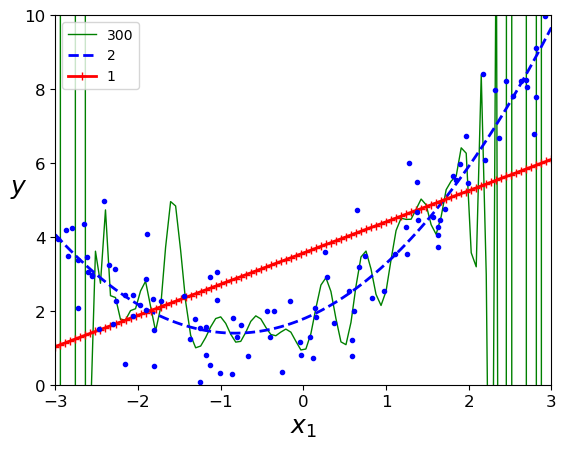

In [34]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

for style, width, degree in (("g-", 1, 300), ("b--", 2, 2), ("r-+", 2, 1)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = Pipeline([
            ("poly_features", polybig_features),
            ("std_scaler", std_scaler),
            ("lin_reg", lin_reg),
        ])
    polynomial_regression.fit(X, y)
    y_newbig = polynomial_regression.predict(X_new)
    plt.plot(X_new, y_newbig, style, label=str(degree), linewidth=width)

plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
plt.show()

이 고차 다항 회귀 모델은 심각하게 훈련 데이터에 과대적합되었습니다. 반면에 선형 모델은 과소적합입니다. 이 경우 가장 일반화가 잘될 모델은 2차 다항 회귀입니다. 2차방정식으로 생성한 데이터이기 때문에 당연한 결과지만 일반적으로는 어떤 함수로 데이터가 생성됐는지 알 수 없습니다. 그러면 얼마나 복잡한 모델을 사용할지 어떻게 결정할 수 있을까요? 어떻게 모델이 데이터에 과대적합 또는 과소적합되었는지 알 수 있을까요?

2장에서 모델의 일반화 성능을 추정하기 위해 교차 검증을 사용했습니다. 훈련 데이터에서 성능이 좋지만 교차 검증 점수가 나쁘다면 모델이 과대적합 것입니다. 만약 양쪽에 모두 좋지 않으면 과소적합입니다. 이때 모델이 너무 단순하거나 너무 복잡하다고 말합니다.

또 다른 방법은 <span style="color: #008000">학습 곡선</span>을 살펴보는 것입니다. 이 그래프는 훈련 세트와 검증 세트의 모델 성능을 훈련 세트 크기(또는 훈련 반복)의 함수로 나타냅니다. 이 그래프를 생성하기 위해서는 단순히 훈련 세트에서 크기가 다른 서브 세트를 만들어 모델을 여러 번 훈련시키면 됩니다. 다음 코드는 주어진 훈련 데이터에서 모델의 학습 곡선을 그리는 함수를 정의합니다.

In [35]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train) + 1):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)
    plt.xlabel("Training set size", fontsize=14)
    plt.ylabel("RMSE", fontsize=14)

단순 선형 회귀 모델(직선)의 학습 곡선을 살펴봅시다.

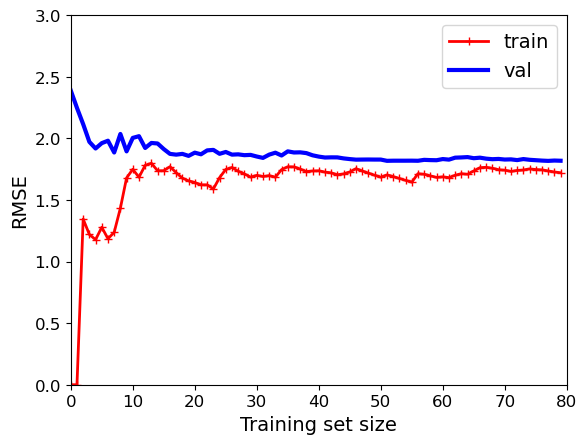

In [36]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)
plt.axis([0, 80, 0, 3])
plt.show()

이 학습 곡선은 이전과 비슷해 보이지만 두 가지 매우 중요한 차이점이 있습니다.

- 훈련 데이터의 오차가 선형 회귀 모델보다 훨씬 낮습니다.
- 두 곡선 사이에 공간이 있습니다. 이 말은 훈련 데이터에서의 모델 성능이 검증 데이터에서보다 훨씬 낫다는 뜻이고, 이는 과대적합 모델의 특징입니다. 그러나 더 큰 훈련 세트를 사용하면 두 곡선이 점점 가까워집니다.